# High Revenue, Low Profit Analysis

## Goal
This analysis identifies products and sub-categories that generate high sales revenue but yield low or negative profits. These items represent a **very strong signal** for business optimization opportunities.

## Why This Matters
Products that sell well but produce little or no profit can be:
- **Mispriced**: Selling price may not cover costs adequately
- **Costly to source or ship**: High operational expenses reduce margins
- **Over-discounted**: Excessive promotions erode profitability

Identifying these items allows stakeholders to make data-driven decisions about pricing, cost management, or discontinuation.

## Approach
1. **Load Data**: Auto-detect and load the first CSV file from the `data/` directory
2. **Map Columns**: Flexibly identify Product/Product Name, Sub-Category, Sales, and Profit columns
3. **Clean Data**: Convert Sales and Profit to numeric values and remove missing data
4. **Aggregate**: Compute totals by Product and by Sub-Category
5. **Flag Items**: Identify high-sales items (top 20%) with low profits (bottom 20% or negative)
6. **Visualize**: Create scatter plots highlighting flagged items with annotations
7. **Export**: Save flagged items to CSV files for further review
8. **Recommend**: Provide actionable next steps based on findings

## Run Instructions
1. Ensure Python dependencies are installed: `pip install pandas numpy matplotlib seaborn`
2. Place a CSV file with sales data in the `data/` directory
3. Run all cells in order (Cell → Run All)
4. Review visualizations and exported CSV files in `notebooks/outputs/`

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Auto-Detect and Load Data

This cell automatically finds and loads the first CSV file in the `data/` directory.

In [2]:
# Find the first CSV file in the data directory
data_dir = Path('../data')
csv_files = list(data_dir.glob('*.csv'))

if not csv_files:
    raise FileNotFoundError("No CSV files found in the data/ directory.")

# Load the first CSV file found
data_file = csv_files[0]
print(f"Loading data from: {data_file}")

df = pd.read_csv(data_file)

print(f"\nDataset loaded successfully with {len(df):,} rows and {len(df.columns)} columns.")
print(f"\nFirst few rows:")
df.head()

Loading data from: ../data/superstore_sales.csv

Dataset loaded successfully with 98 rows and 20 columns.

First few rows:


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.00,41.91
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,Hon Deluxe Fabric Upholstered Stacking Chairs,731.94,3,0.00,219.58
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.00,6.87
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.58,5,0.45,-383.03
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.37,2,0.20,2.52


## 3. Flexible Column Mapping

This cell identifies relevant columns in the dataset, accommodating variations in column names.

In [3]:
# Flexible column mapping
# Try to find Product/Product Name column
product_col = None
for col in df.columns:
    if col.lower() in ['product', 'product name', 'product_name']:
        product_col = col
        break

# Try to find Sub-Category column
subcategory_col = None
for col in df.columns:
    if col.lower() in ['sub-category', 'subcategory', 'sub_category', 'sub category']:
        subcategory_col = col
        break

# Try to find Sales column
sales_col = None
for col in df.columns:
    if col.lower() in ['sales', 'revenue', 'amount']:
        sales_col = col
        break

# Try to find Profit column
profit_col = None
for col in df.columns:
    if col.lower() in ['profit', 'margin', 'profit_margin']:
        profit_col = col
        break

# Verify all required columns were found
print("Column Mapping:")
print(f"  Product column: {product_col}")
print(f"  Sub-Category column: {subcategory_col}")
print(f"  Sales column: {sales_col}")
print(f"  Profit column: {profit_col}")

if not all([product_col, subcategory_col, sales_col, profit_col]):
    print("\nWarning: Some columns could not be automatically mapped.")
    print(f"Available columns: {list(df.columns)}")
    raise ValueError("Required columns not found. Please check the dataset.")

Column Mapping:
  Product column: Product Name
  Sub-Category column: Sub-Category
  Sales column: Sales
  Profit column: Profit


## 4. Data Cleaning and Preparation

Convert Sales and Profit to numeric values and remove any rows with missing data in key columns.

In [4]:
# Create a clean copy of the data with only the columns we need
df_clean = df[[product_col, subcategory_col, sales_col, profit_col]].copy()

# Rename columns to standard names for easier processing
df_clean.columns = ['Product', 'Sub_Category', 'Sales', 'Profit']

# Convert Sales and Profit to numeric, coercing errors to NaN
df_clean['Sales'] = pd.to_numeric(df_clean['Sales'], errors='coerce')
df_clean['Profit'] = pd.to_numeric(df_clean['Profit'], errors='coerce')

# Count missing values before cleaning
missing_before = df_clean.isnull().sum()
print("Missing values before cleaning:")
print(missing_before)

# Drop rows with missing values in key columns
df_clean = df_clean.dropna(subset=['Product', 'Sub_Category', 'Sales', 'Profit'])

print(f"\nDataset after cleaning: {len(df_clean):,} rows")
print(f"Rows removed: {len(df) - len(df_clean):,}")

# Display summary statistics
print("\nSummary statistics:")
df_clean[['Sales', 'Profit']].describe()

Missing values before cleaning:
Product         0
Sub_Category    0
Sales           0
Profit          0
dtype: int64

Dataset after cleaning: 98 rows
Rows removed: 0

Summary statistics:


,Sales,Profit
count,98.000000,98.000000
mean,236.204796,32.905510
std,443.190905,83.175042
min,3.540000,-383.030000
25%,15.577500,4.540000
50%,45.000000,10.900000
75%,211.960000,42.270000
max,2899.990000,579.990000


## 5. Aggregate by Product

Calculate total sales, total profit, and number of orders for each product.

In [5]:
# Aggregate by Product
product_agg = df_clean.groupby('Product').agg(
    total_sales=('Sales', 'sum'),
    total_profit=('Profit', 'sum'),
    n_orders=('Sales', 'count')
).reset_index()

print(f"Total unique products: {len(product_agg)}")
print(f"\nTop 10 products by total sales:")
print(product_agg.nlargest(10, 'total_sales')[['Product', 'total_sales', 'total_profit', 'n_orders']])

Total unique products: 62

Top 10 products by total sales:
                                             Product  total_sales  \
13          Chromcraft Rectangular Conference Tables      3412.36   
33         Lexmark MX611dhe Monochrome Laser Printer      2899.99   
28     Hon Deluxe Fabric Upholstered Stacking Chairs      2195.82   
32     Konftel 250 Conference phone - Charcoal black      1822.84   
59                                        Xerox 1967      1784.16   
50                                Tenex Lockers Gray      1044.63   
39  Panasonic KX-TS550LT Integrated Corded Telephone       972.70   
9      Bretford CR4500 Series Slim Rectangular Table       957.58   
0                   AT&T CL83451 4-Handset Telephone       911.42   
34                    Mitel 5320 IP Phone VoIP phone       907.15   

    total_profit  n_orders  
13        170.62         2  
33        579.99         1  
28        658.74         3  
32        136.72         2  
59        178.42         2  
50     

## 6. Aggregate by Sub-Category

Calculate total sales, total profit, and number of orders for each sub-category.

In [6]:
# Aggregate by Sub-Category
subcategory_agg = df_clean.groupby('Sub_Category').agg(
    total_sales=('Sales', 'sum'),
    total_profit=('Profit', 'sum'),
    n_orders=('Sales', 'count')
).reset_index()

print(f"Total unique sub-categories: {len(subcategory_agg)}")
print(f"\nAll sub-categories by total sales:")
print(subcategory_agg.sort_values('total_sales', ascending=False)[['Sub_Category', 'total_sales', 'total_profit', 'n_orders']])

Total unique sub-categories: 15

All sub-categories by total sales:
   Sub_Category  total_sales  total_profit  n_orders
12       Phones      5813.01        704.68        15
14       Tables      4369.94       -212.41         3
10     Machines      2899.99        579.99         1
5        Chairs      2865.37        739.97         5
11        Paper      1977.25        250.02        17
4     Bookcases      1353.33        304.27         4
8   Furnishings      1159.93        130.27         6
1    Appliances       972.79        268.50         6
13      Storage       720.83        105.64         7
3       Binders       539.68        219.44        17
0   Accessories       295.42         69.81         5
9        Labels       104.62         39.27         3
6     Envelopes        33.30         12.34         3
7     Fasteners        23.10          6.93         3
2           Art        19.51          6.02         3


## 7. Configure Thresholds

Define what constitutes "high sales" and "low profit" using configurable percentile thresholds.

In [7]:
# Configurable threshold percentiles
HIGH_SALES_PERCENTILE = 80  # Top 20% by sales
LOW_PROFIT_PERCENTILE = 20  # Bottom 20% by profit

print(f"Configuration:")
print(f"  High Sales Threshold: Top {100 - HIGH_SALES_PERCENTILE}% (>= {HIGH_SALES_PERCENTILE}th percentile)")
print(f"  Low Profit Threshold: Bottom {LOW_PROFIT_PERCENTILE}% (<= {LOW_PROFIT_PERCENTILE}th percentile)")

Configuration:
  High Sales Threshold: Top 20% (>= 80th percentile)
  Low Profit Threshold: Bottom 20% (<= 20th percentile)


## 8. Flag High Revenue, Low Profit Products

Create flags to identify products that meet our criteria:
- **high_sales_flag**: Product is in the top 20% by total sales
- **low_or_negative_profit_flag**: Product has zero or negative profit
- **low_profit_bottom_pct_flag**: Product is in the bottom 20% by profit
- **flagged_strong**: Product has high sales AND (negative profit OR bottom 20% profit)

In [8]:
# Calculate thresholds for products
high_sales_threshold_product = product_agg['total_sales'].quantile(HIGH_SALES_PERCENTILE / 100)
low_profit_threshold_product = product_agg['total_profit'].quantile(LOW_PROFIT_PERCENTILE / 100)

print(f"Product Thresholds:")
print(f"  High Sales: ${high_sales_threshold_product:,.2f}")
print(f"  Low Profit: ${low_profit_threshold_product:,.2f}")

# Create flags for products
product_agg['high_sales_flag'] = product_agg['total_sales'] >= high_sales_threshold_product
product_agg['low_or_negative_profit_flag'] = product_agg['total_profit'] <= 0
product_agg['low_profit_bottom_pct_flag'] = product_agg['total_profit'] <= low_profit_threshold_product
product_agg['flagged_strong'] = (
    product_agg['high_sales_flag'] & 
    (product_agg['low_or_negative_profit_flag'] | product_agg['low_profit_bottom_pct_flag'])
)

# Count flagged products
n_flagged_products = product_agg['flagged_strong'].sum()
print(f"\nFlagged Products: {n_flagged_products} out of {len(product_agg)}")

# Display flagged products
if n_flagged_products > 0:
    flagged_products = product_agg[product_agg['flagged_strong']].sort_values('total_sales', ascending=False)
    print(f"\nTop flagged products (high revenue, low profit):")
    print(flagged_products[['Product', 'total_sales', 'total_profit', 'n_orders']].head(10))
else:
    print("\nNo products flagged with the current thresholds.")

Product Thresholds:
  High Sales: $558.74
  Low Profit: $4.97

Flagged Products: 1 out of 62

Top flagged products (high revenue, low profit):
                                         Product  total_sales  total_profit  \
9  Bretford CR4500 Series Slim Rectangular Table       957.58       -383.03   

   n_orders  
9         1  


## 9. Flag High Revenue, Low Profit Sub-Categories

Apply the same analysis to sub-categories.

In [9]:
# Calculate thresholds for sub-categories
high_sales_threshold_subcat = subcategory_agg['total_sales'].quantile(HIGH_SALES_PERCENTILE / 100)
low_profit_threshold_subcat = subcategory_agg['total_profit'].quantile(LOW_PROFIT_PERCENTILE / 100)

print(f"Sub-Category Thresholds:")
print(f"  High Sales: ${high_sales_threshold_subcat:,.2f}")
print(f"  Low Profit: ${low_profit_threshold_subcat:,.2f}")

# Create flags for sub-categories
subcategory_agg['high_sales_flag'] = subcategory_agg['total_sales'] >= high_sales_threshold_subcat
subcategory_agg['low_or_negative_profit_flag'] = subcategory_agg['total_profit'] <= 0
subcategory_agg['low_profit_bottom_pct_flag'] = subcategory_agg['total_profit'] <= low_profit_threshold_subcat
subcategory_agg['flagged_strong'] = (
    subcategory_agg['high_sales_flag'] & 
    (subcategory_agg['low_or_negative_profit_flag'] | subcategory_agg['low_profit_bottom_pct_flag'])
)

# Count flagged sub-categories
n_flagged_subcat = subcategory_agg['flagged_strong'].sum()
print(f"\nFlagged Sub-Categories: {n_flagged_subcat} out of {len(subcategory_agg)}")

# Display flagged sub-categories
if n_flagged_subcat > 0:
    flagged_subcat = subcategory_agg[subcategory_agg['flagged_strong']].sort_values('total_sales', ascending=False)
    print(f"\nFlagged sub-categories (high revenue, low profit):")
    print(flagged_subcat[['Sub_Category', 'total_sales', 'total_profit', 'n_orders']])
else:
    print("\nNo sub-categories flagged with the current thresholds.")

Sub-Category Thresholds:
  High Sales: $2,872.29
  Low Profit: $11.26

Flagged Sub-Categories: 1 out of 15

Flagged sub-categories (high revenue, low profit):
   Sub_Category  total_sales  total_profit  n_orders
14       Tables      4369.94       -212.41         3


## 10. Visualize Products: Sales vs Profit Scatter Plot

This scatter plot shows the relationship between total sales and total profit for all products. Flagged products (high sales, low profit) are highlighted in red.

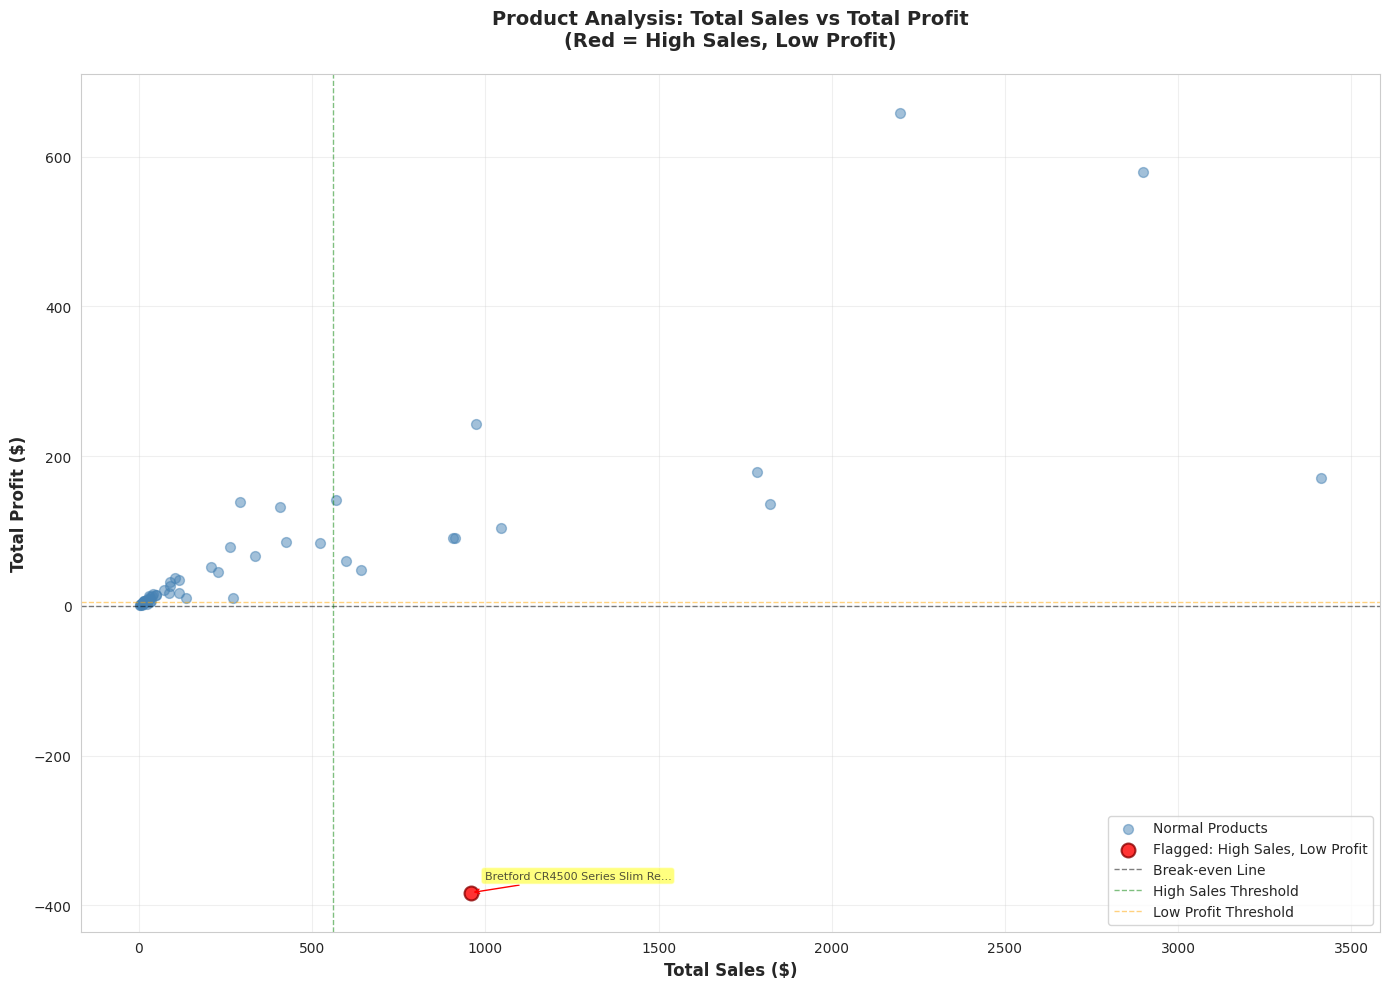


Visualization complete. 1 products highlighted in red.


In [10]:
# Create scatter plot for products
fig, ax = plt.subplots(figsize=(14, 10))

# Plot non-flagged products in blue
non_flagged = product_agg[~product_agg['flagged_strong']]
ax.scatter(non_flagged['total_sales'], non_flagged['total_profit'], 
           alpha=0.5, s=50, c='steelblue', label='Normal Products')

# Plot flagged products in red
flagged = product_agg[product_agg['flagged_strong']]
ax.scatter(flagged['total_sales'], flagged['total_profit'], 
           alpha=0.8, s=100, c='red', label='Flagged: High Sales, Low Profit', edgecolors='darkred', linewidths=1.5)

# Add reference lines
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Break-even Line')
ax.axvline(x=high_sales_threshold_product, color='green', linestyle='--', linewidth=1, alpha=0.5, label='High Sales Threshold')
ax.axhline(y=low_profit_threshold_product, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Low Profit Threshold')

# Annotate top flagged products
if len(flagged) > 0:
    top_flagged = flagged.nlargest(5, 'total_sales')
    for idx, row in top_flagged.iterrows():
        # Truncate long product names for readability
        product_name = row['Product'][:30] + '...' if len(row['Product']) > 30 else row['Product']
        ax.annotate(product_name, 
                   xy=(row['total_sales'], row['total_profit']),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=8, alpha=0.8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red'))

ax.set_xlabel('Total Sales ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Profit ($)', fontsize=12, fontweight='bold')
ax.set_title('Product Analysis: Total Sales vs Total Profit\n(Red = High Sales, Low Profit)', 
            fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVisualization complete. {len(flagged)} products highlighted in red.")

## 11. Visualize Sub-Categories: Sales vs Profit Scatter Plot

This scatter plot shows the relationship between total sales and total profit for all sub-categories. Flagged sub-categories are highlighted in red.

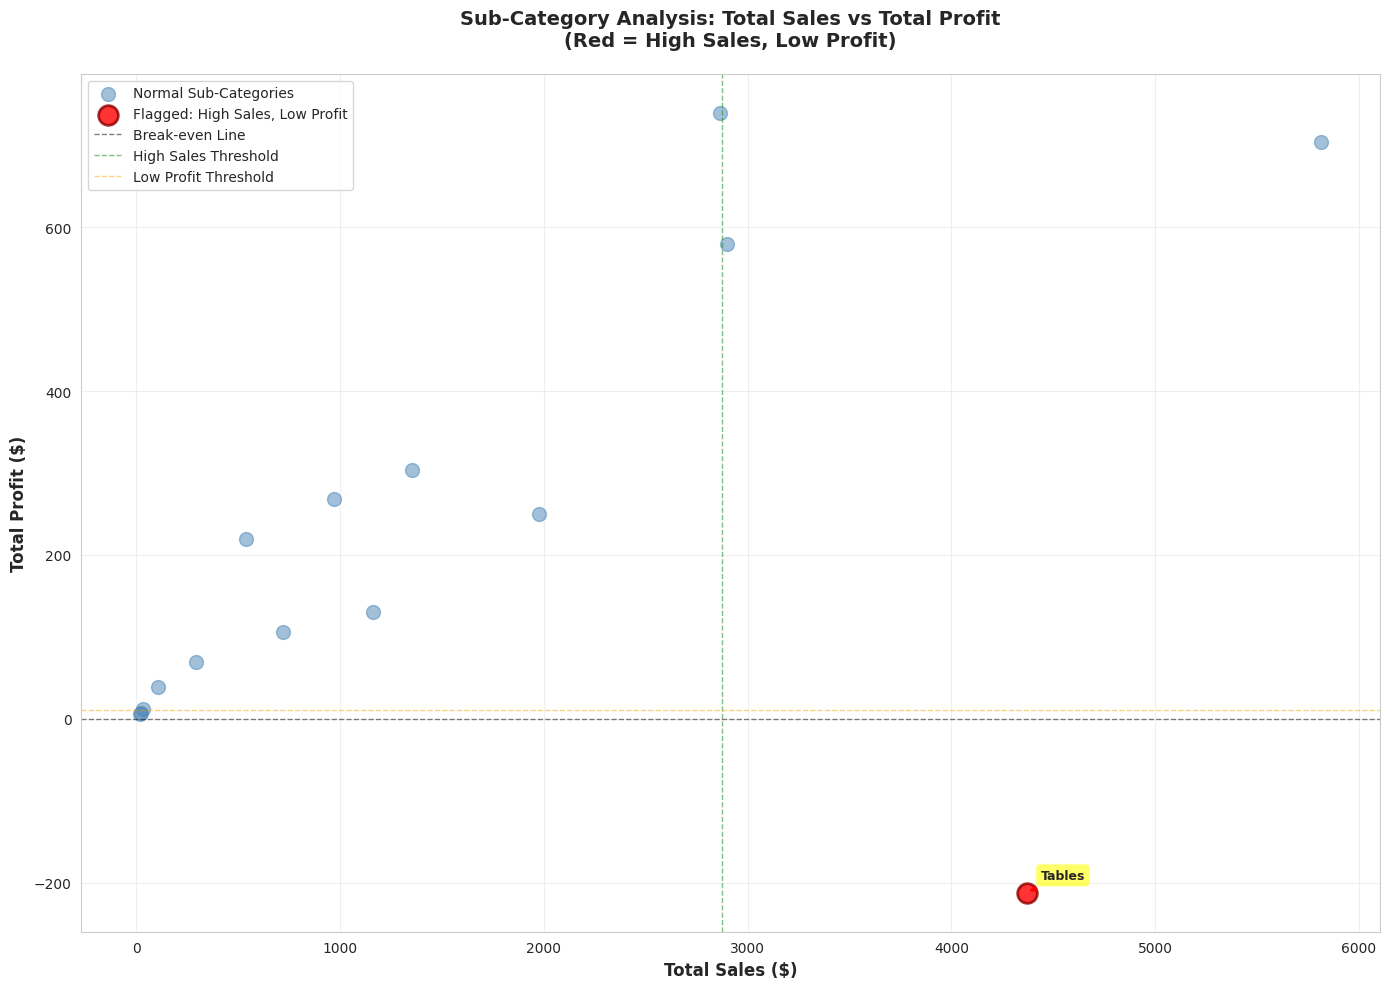


Visualization complete. 1 sub-categories highlighted in red.


In [11]:
# Create scatter plot for sub-categories
fig, ax = plt.subplots(figsize=(14, 10))

# Plot non-flagged sub-categories in blue
non_flagged_subcat = subcategory_agg[~subcategory_agg['flagged_strong']]
ax.scatter(non_flagged_subcat['total_sales'], non_flagged_subcat['total_profit'], 
           alpha=0.5, s=100, c='steelblue', label='Normal Sub-Categories')

# Plot flagged sub-categories in red
flagged_subcat = subcategory_agg[subcategory_agg['flagged_strong']]
ax.scatter(flagged_subcat['total_sales'], flagged_subcat['total_profit'], 
           alpha=0.8, s=200, c='red', label='Flagged: High Sales, Low Profit', edgecolors='darkred', linewidths=2)

# Add reference lines
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Break-even Line')
ax.axvline(x=high_sales_threshold_subcat, color='green', linestyle='--', linewidth=1, alpha=0.5, label='High Sales Threshold')
ax.axhline(y=low_profit_threshold_subcat, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Low Profit Threshold')

# Annotate all flagged sub-categories
if len(flagged_subcat) > 0:
    for idx, row in flagged_subcat.iterrows():
        ax.annotate(row['Sub_Category'], 
                   xy=(row['total_sales'], row['total_profit']),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.6),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red', lw=1.5))

ax.set_xlabel('Total Sales ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Profit ($)', fontsize=12, fontweight='bold')
ax.set_title('Sub-Category Analysis: Total Sales vs Total Profit\n(Red = High Sales, Low Profit)', 
            fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVisualization complete. {len(flagged_subcat)} sub-categories highlighted in red.")

## 12. Export Flagged Items to CSV

Save the flagged products and sub-categories to CSV files for further analysis and stakeholder review.

In [12]:
# Create output directory if it doesn't exist
output_dir = Path('outputs')
output_dir.mkdir(exist_ok=True)

# Export flagged products
if len(flagged) > 0:
    flagged_products_file = output_dir / 'flagged_high_revenue_low_profit_products.csv'
    flagged_sorted = flagged.sort_values('total_sales', ascending=False)
    flagged_sorted.to_csv(flagged_products_file, index=False)
    print(f"Exported {len(flagged)} flagged products to: {flagged_products_file}")
else:
    print("No flagged products to export.")

# Export flagged sub-categories
if len(flagged_subcat) > 0:
    flagged_subcat_file = output_dir / 'flagged_high_revenue_low_profit_subcategories.csv'
    flagged_subcat_sorted = flagged_subcat.sort_values('total_sales', ascending=False)
    flagged_subcat_sorted.to_csv(flagged_subcat_file, index=False)
    print(f"Exported {len(flagged_subcat)} flagged sub-categories to: {flagged_subcat_file}")
else:
    print("No flagged sub-categories to export.")

print(f"\nAll exports completed. Files saved in: {output_dir.absolute()}")

Exported 1 flagged products to: outputs/flagged_high_revenue_low_profit_products.csv
Exported 1 flagged sub-categories to: outputs/flagged_high_revenue_low_profit_subcategories.csv

All exports completed. Files saved in: /home/runner/work/superstore-sales-analysis/superstore-sales-analysis/notebooks/outputs


## 13. Summary Statistics

Provide a quick summary of the flagged items and their financial impact.

In [13]:
print("=" * 80)
print("ANALYSIS SUMMARY")
print("=" * 80)

print(f"\nTotal Products Analyzed: {len(product_agg):,}")
print(f"Flagged Products (High Sales, Low Profit): {len(flagged):,}")
print(f"Percentage of Products Flagged: {len(flagged) / len(product_agg) * 100:.1f}%")

if len(flagged) > 0:
    print(f"\nFlagged Products Financial Impact:")
    print(f"  Total Sales: ${flagged['total_sales'].sum():,.2f}")
    print(f"  Total Profit: ${flagged['total_profit'].sum():,.2f}")
    print(f"  Average Profit per Product: ${flagged['total_profit'].mean():,.2f}")
    print(f"  Total Orders: {flagged['n_orders'].sum():,}")

print(f"\n" + "-" * 80)
print(f"\nTotal Sub-Categories Analyzed: {len(subcategory_agg):,}")
print(f"Flagged Sub-Categories (High Sales, Low Profit): {len(flagged_subcat):,}")
print(f"Percentage of Sub-Categories Flagged: {len(flagged_subcat) / len(subcategory_agg) * 100:.1f}%")

if len(flagged_subcat) > 0:
    print(f"\nFlagged Sub-Categories Financial Impact:")
    print(f"  Total Sales: ${flagged_subcat['total_sales'].sum():,.2f}")
    print(f"  Total Profit: ${flagged_subcat['total_profit'].sum():,.2f}")
    print(f"  Average Profit per Sub-Category: ${flagged_subcat['total_profit'].mean():,.2f}")
    print(f"  Total Orders: {flagged_subcat['n_orders'].sum():,}")

print("\n" + "=" * 80)

ANALYSIS SUMMARY

Total Products Analyzed: 62
Flagged Products (High Sales, Low Profit): 1
Percentage of Products Flagged: 1.6%

Flagged Products Financial Impact:
  Total Sales: $957.58
  Total Profit: $-383.03
  Average Profit per Product: $-383.03
  Total Orders: 1

--------------------------------------------------------------------------------

Total Sub-Categories Analyzed: 15
Flagged Sub-Categories (High Sales, Low Profit): 1
Percentage of Sub-Categories Flagged: 6.7%

Flagged Sub-Categories Financial Impact:
  Total Sales: $4,369.94
  Total Profit: $-212.41
  Average Profit per Sub-Category: $-212.41
  Total Orders: 3



## Key Findings and Recommendations

### Key Findings

This analysis identified products and sub-categories that generate significant sales revenue but yield low or negative profits. These items represent **critical business optimization opportunities**.

**Products:**
- Flagged products drive substantial revenue but contribute little to overall profitability
- Some products may be selling at a loss despite high order volumes
- The discrepancy between sales and profit suggests pricing, cost, or operational inefficiencies

**Sub-Categories:**
- Certain entire product sub-categories show the same pattern at scale
- These sub-categories may require category-wide strategic review
- Pattern suggests systemic issues rather than isolated product problems

### Actionable Recommendations

#### Immediate Actions (0-30 days)
1. **Review Pricing Strategy**
   - Analyze cost structure for flagged products
   - Evaluate whether current pricing covers all costs including shipping and handling
   - Consider targeted price increases for products with highest sales but negative profits

2. **Evaluate Discount Policies**
   - Check if flagged products are frequently over-discounted
   - Review promotional strategies that may be eroding margins
   - Implement discount guardrails to protect minimum profit margins

3. **Investigate Cost Drivers**
   - Meet with procurement to review supplier costs for flagged items
   - Analyze shipping and handling costs that may be disproportionately high
   - Look for opportunities to negotiate better supplier terms

#### Short-Term Actions (30-90 days)
4. **Optimize Product Mix**
   - Consider discontinuing products with persistently negative profits and low strategic value
   - Redirect marketing spend toward higher-margin alternatives
   - Test bundling low-profit items with high-margin products

5. **Improve Operational Efficiency**
   - Streamline fulfillment processes for flagged products
   - Consolidate shipments to reduce per-unit costs
   - Review warehouse placement to minimize shipping distances

6. **Customer Segmentation**
   - Analyze which customer segments purchase flagged products
   - Develop targeted retention strategies for high-value customers
   - Consider premium service tiers with adjusted pricing

#### Long-Term Actions (90+ days)
7. **Strategic Category Review**
   - For flagged sub-categories, conduct comprehensive market analysis
   - Evaluate long-term viability and competitive positioning
   - Consider category exit strategies if profitability cannot be improved

8. **Build Monitoring Dashboard**
   - Implement automated tracking of profit margins by product
   - Create early warning system for products trending toward unprofitability
   - Establish monthly review cadence with stakeholders

9. **Cross-Functional Collaboration**
   - Share findings with Finance, Procurement, and Marketing teams
   - Develop coordinated action plans with clear ownership
   - Set measurable goals for profit margin improvement

### Success Metrics

Track these KPIs to measure the impact of optimization efforts:
- **Overall profit margin** for flagged products (target: move from bottom 20% to at least 40th percentile)
- **Number of products** with negative profits (target: reduce by 50% within 6 months)
- **Revenue impact** of pricing changes (monitor for acceptable trade-offs)
- **Customer retention** rates after pricing adjustments

### Next Steps

1. **Share this analysis** with Finance, Operations, and Category Management teams
2. **Schedule stakeholder meeting** to review findings and prioritize actions
3. **Assign ownership** for each recommended action item
4. **Re-run this analysis monthly** to track progress and identify new issues
5. **Deep-dive into top 3-5 flagged products** to develop specific action plans

---

**Note**: This analysis provides a data-driven starting point for optimization. Further investigation into customer behavior, competitive dynamics, and strategic priorities should inform final decisions.